In [155]:
import numpy as np

In [156]:
OFF = np.genfromtxt(r'/home/drtofa/OneDrive/QTLab2324/DATA ANALYSIS/OPTIMUM/TXT/OFF_Tension.txt')

In [157]:
import matplotlib.pyplot as plt

In [158]:
def FWHM(x,hist):
    halfs = x[np.where(hist < max(hist)/2)]
    mx = max(hist[np.where(hist < max(hist)/2)])
    idx = np.where(hist==max(hist[np.where(hist < max(hist)/2)]))[0]
    return x[idx+1]-x[idx-1]

In [159]:
def plot(OFF, bin_centers,hist, m, func):
    idx = OFF > 0.001
    fig = plt.figure(figsize=(15, 6))
    fig.tight_layout()
    plt.errorbar(bin_centers, hist,np.sqrt(hist+1), alpha=0.5, label='Data', fmt='ko', color='blue')
    plt.errorbar(bin_centers, func(bin_centers,*m.values),np.sqrt(func(bin_centers,*m.values)), fmt='ko',color='black',linestyle='-', label='MIGRAD',alpha=0.8)
    plt.hist(OFF[idx],80,histtype='stepfilled',color='lightblue',density=False,alpha=0.5)
    plt.xlabel('Energy [eV]')
    plt.ylabel('Counts')
    plt.title('OFF Fit')
    plt.grid(True)

    title = []
    for par in m.parameters:
        title.append(
            f"{par} = {m.values[par]:.5f} +/- {m.errors[par]:.5f}"
        )
    title.append(r'$\chi^{2}_{0} = $'+f"{m.fval/m.ndof:.2f}")

    # Create the legend
    legend = plt.legend(title="\n".join(title),fontsize=10)

    # Adjust the title's font size
    legend.get_title().set_fontsize(10)  # or use a numeric value like 8

In [160]:
amp = OFF[np.where(OFF > 0.001)[0]]

In [330]:
#q25, q75 = np.percentile(amp, [25, 75])
#bin_width = 2 * (q75 - q25) / np.cbrt(len(amp))
#bins = int((amp.max() - amp.min()) / bin_width)
bins = int(np.sqrt(amp.shape[0]))
hist, bin_edges = np.histogram(amp, bins=bins, density=False)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

In [331]:
from scipy.signal import find_peaks

In [332]:
ppos, pprop = find_peaks(hist,0)

In [333]:
x = bin_centers

In [414]:
from scipy.special import factorial

def gauss(x, mu, sigma):
    return 1/(np.sqrt(2*np.pi)*sigma) * np.exp(-((x-mu)**2)/(2*sigma**2))

def poiss(n,l):
    return  np.exp(-l)*pow(l,n)/factorial(n)

<ErrorbarContainer object of 3 artists>

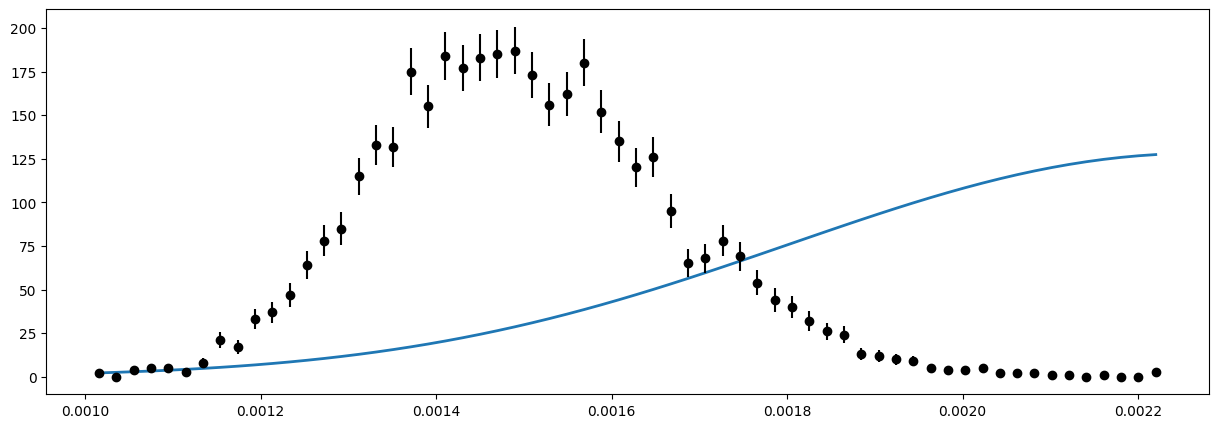

In [428]:
N  = 20
sigma = 0.0003
A  = np.sqrt(2*np.pi)*sigma*200
b = 0.0001
d = 0.001
l = 13
ns = np.linspace(1,N,N)
#x = np.linspace(0,60,1000)
plt.figure(figsize=(15,5))
values = []
temp = np.zeros(x.shape[0])
for n in (ns):
    temp += A*poiss(n,l)*gauss(x,n*b+d,sigma) 
values.append(temp)
#if l==10:
plt.plot(x,values[0],linewidth=2)
plt.errorbar(x,hist,np.sqrt(hist),fmt='ko')


In [204]:
#b = 9/0.002
mu = 20
N = int(mu + 3 * np.sqrt(mu))
A     = 1/200
b     = 0.00001
sigma = 3*b
d     = 0.00107
p     = [A, mu, b, sigma, d]

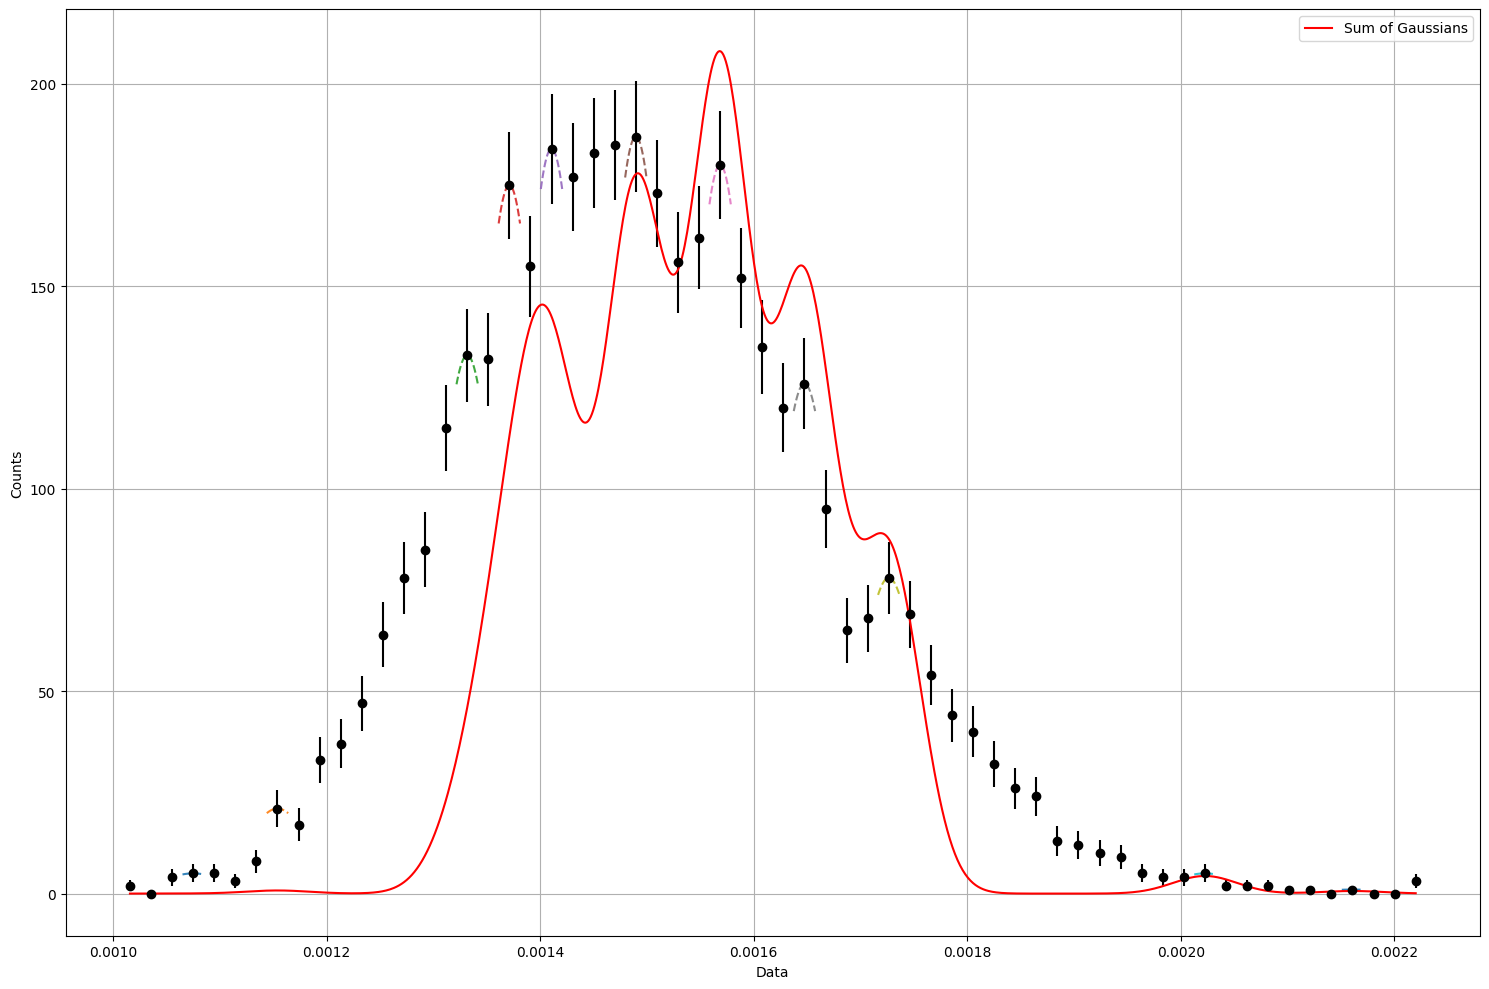

In [152]:
from scipy.special import factorial

fig = plt.figure(figsize=(15, 10))
fig.tight_layout()
plt.errorbar(x,hist,np.sqrt(hist),fmt='ko')
#plt.hist(amp,bins,density=False,histtype='step',alpha=0.8,color='black')
val = 0

temps = np.linspace(min(x), max(x), 1000)
total_vals = np.zeros_like(temps)

# Loop over positions and plot individual Gaussians
for n,pos in enumerate(ppos):
    temp = np.linspace(x[pos] - b, x[pos] + b, 100)
    vals = gauss(temp, hist[pos], x[pos], sigma)
    
    # Plot each Gaussian
    plt.plot(temp, vals, alpha=0.9, linestyle='--')
    # Accumulate the Gaussian values
    total_vals += gauss(temps, hist[pos], x[pos], sigma )*np.exp(-n)*pow(mu,n)/factorial(n)*A

# Plot the sum of Gaussians
plt.plot(temps, total_vals, color='red', label='Sum of Gaussians')

# Labels and aesthetics
plt.xlabel('Data')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.tight_layout()  # Move this here, after all plotting is done

In [153]:
from scipy.special import factorial


def model(amplitudes, A, mu, b, sigma):
    """
    Compute the sum over n of P(n; µ)·G(OFF-nb)
    
    Parameters:
    - amplitudes: Array of measured amplitudes (OFF).
    - N: Maximum number of photons to consider.
    - mu: Mean of the Poisson distribution.
    - b: Conversion from amplitudes to eV
    - sigma: Standard deviation of the Gaussian distribution.
    
    Returns:
    - Array of computed values for the given amplitudes.
    """
    # Initialize result array
    result = np.zeros_like(amplitudes)
    
    # Compute the Gaussian PDF for each photon number and sum up
    for n in range(N):
        # Compute Gaussian PDF for the current number of photons
        values = (pow(mu,n)*np.exp(-n)/factorial(n)) * np.exp(-((amplitudes-b*n-d)**2)/(2*sigma**2))
        
        # Update result array
        result += values
    
    return A* result

In [154]:
values = model(x, *p)

TypeError: model() takes 5 positional arguments but 6 were given

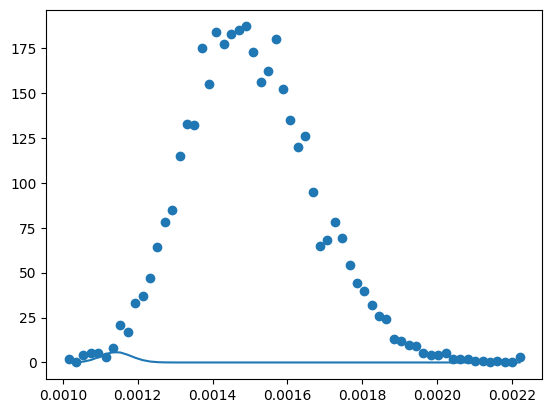

In [50]:
plt.plot(x,model_values3)
plt.scatter(x, hist)

In [51]:
from iminuit import minuit
from iminuit.cost import LeastSquares

In [52]:
lsq = LeastSquares(x,hist,np.sqrt(hist+1),compute_sum_poisson_gaussian_3)
m = minuit.Minuit(lsq, *p)
#m.fixed['b'] = True
m.limits['mu']   = (1,np.inf)
m.limits['sigma']   = (sigma/2,sigma*2)
m.migrad();

In [53]:
x_final = (x-m.values['d'])/m.values['b']

Text(0.5, 1.0, 'FINAL FIT')

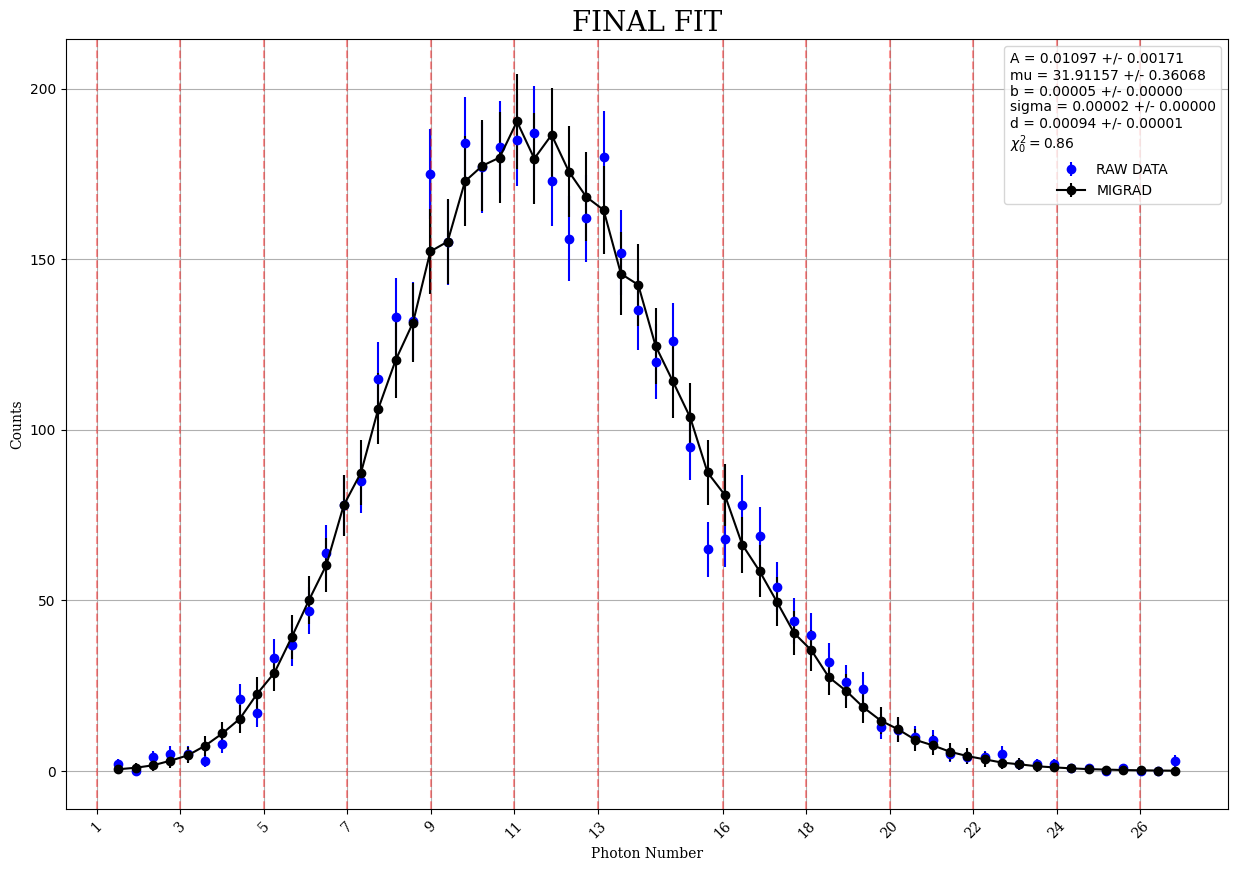

In [54]:
fig = plt.figure(figsize=(15, 10))
fig.tight_layout()
plt.errorbar(x_final,hist,np.sqrt(hist),fmt='bo',label='RAW DATA')
#plt.hist(amp,bins,density=False,histtype='stepfilled',alpha=0.2,color='lightblue')
plt.errorbar(x_final,compute_sum_poisson_gaussian_3(x,*m.values),np.sqrt(compute_sum_poisson_gaussian_3(x,*m.values)+1),fmt='ko-',label='MIGRAD')
plt.xlabel('Photon Number', fontsize=10, fontfamily='serif')
plt.ylabel('Counts', fontsize=10, fontfamily='serif')
plt.legend()
plt.grid()

numbers = np.arange(min(x_final),max(x_final),1)
ticks = []
for n in x_final[::5]:
    plt.axvline(int(n),0,1,linestyle='--',alpha=0.4,color='red')
    ticks.append(int(n))

title = []
for par in m.parameters:
    title.append(
        f"{par} = {m.values[par]:.5f} +/- {m.errors[par]:.5f}"
    )
title.append(r'$\chi^{2}_{0} = $'+f"{m.fval/m.ndof:.2f}")

# Create the legend
legend = plt.legend(title="\n".join(title),fontsize=10)
plt.xticks(ticks,fontsize=10,fontfamily='serif',rotation=45)
#plt.set_yticksfont('serif')
#plt.yticks(compute_sum_poisson_gaussian_3(x,*m.values)[::10],fontsize=10,fontfamily='serif',rotation=45)
# Adjust the title's font size
legend.get_title().set_fontsize(10)  # or use a numeric value like 8
plt.title('FINAL FIT',fontsize=20,fontfamily='serif')

/tmp/ipykernel_14967/2567607433.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


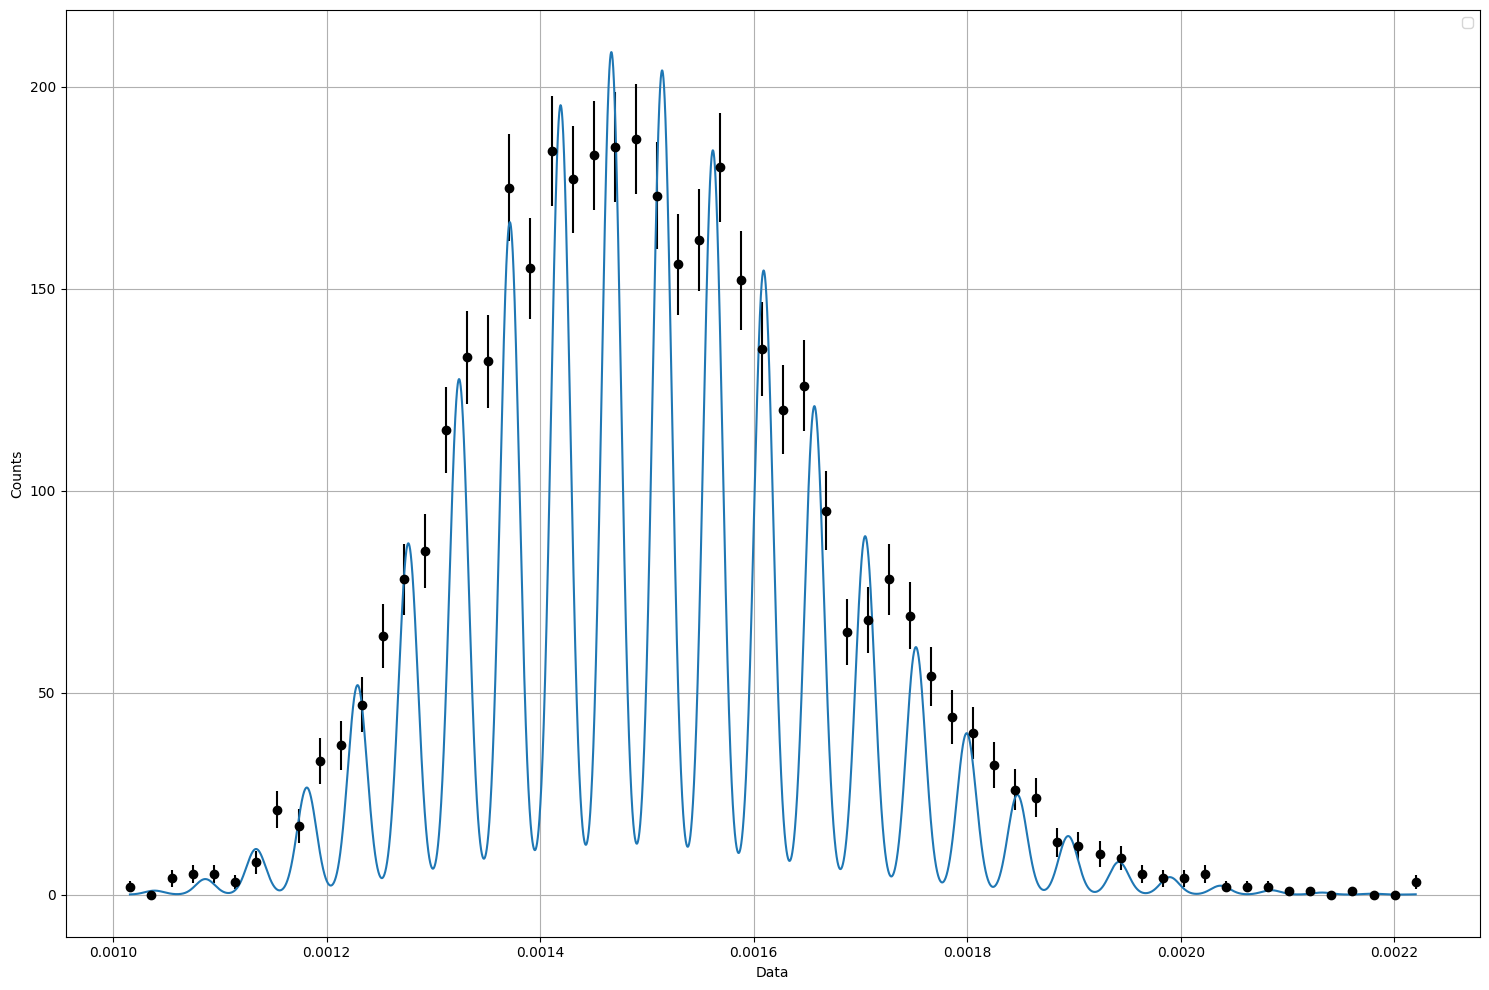

In [71]:
from scipy.special import factorial

fig = plt.figure(figsize=(15, 10))
fig.tight_layout()
plt.errorbar(x,hist,np.sqrt(hist),fmt='ko')
plt.plot(np.linspace(min(x),max(x),100000),compute_sum_poisson_gaussian_3(np.linspace(min(x),max(x),100000),m.values['A']*1.3,m.values['mu'],m.values['b'],0.000009,m.values['d']))
# Labels and aesthetics
plt.xlabel('Data')
plt.ylabel('Counts')
plt.legend()
plt.grid()
plt.tight_layout()  # Move this here, after all plotting is done